<a href="https://colab.research.google.com/github/JEN6YT/APS360/blob/main/Jennifer_Lab3_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/18oSEei8V99engFZU3GbpJ_qSTznP6jND#scrollTo=LfiFE_WOqIDu

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). **Ensure enough comments are included in the code so that**
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

**Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?**

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [ ]:
# obtain data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/U of T/APS360 Deep Learning/data/'

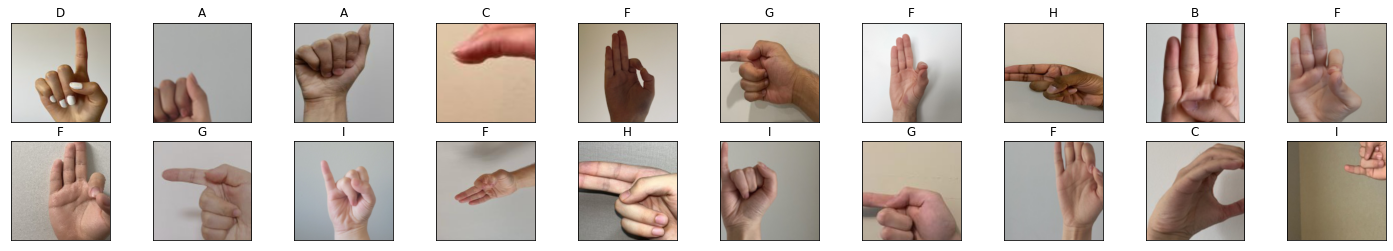

In [ ]:
# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

# divide the data into different datasets using ImageFolder
train_dataset = torchvision.datasets.ImageFolder(path+'train', transform=data_transform) # training data is 80% of the data
val_dataset = torchvision.datasets.ImageFolder(path+'val', transform=data_transform) # validation data is 15%
test_dataset = torchvision.datasets.ImageFolder(path+'test', transform=data_transform) # testing data is 5%

# define dataloader parameters to load the data
batch_size  = 30 # divide the data into multiple batches
num_workers = 1 # parallel workers to load the data to increase loading efficiency

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

# Visualize some sample data
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
torch.manual_seed(1) # set the random seed
from math import floor

class CNNClassifier(nn.Module):
    def __init__(self, kernel_sizes = [10, 5, 3]):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_sizes[0])
        self.conv2 = nn.Conv2d(5, 10, kernel_sizes[1])
        self.conv3 = nn.Conv2d(10, 25, kernel_sizes[2])

        self.pool = nn.MaxPool2d(2, 2)

        # Computing the correct input size into the Fully Connected Layer
        self.x = floor((224 - kernel_sizes[0] + 1)/2)
        self.y = floor((self.x - kernel_sizes[1] + 1)/2)
        self.z = floor((self.y - kernel_sizes[2] + 1)/2)
        self.FC_input = 25*self.z*self.z

        self.fc1 = nn.Linear(self.FC_input, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.FC_input)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
use_cuda = True

In [ ]:
def get_accuracy(model, data):
    correct = 0
    total = 0

    for imgs, labels in data:

      if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

      output = model(imgs)
      pred = output.max(1, keepdim=True)[1] # get the index of the max logit
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
    return correct / total


In [ ]:
def train(model, train_dataset, val_dataset, batch_size=128, num_epochs=20, learning_rate=0.001):
    torch.manual_seed(10)
    # loss function is the cross entropy loss becuase it is the most popular loss function so far and it is effective 
    criterion = nn.CrossEntropyLoss() 
    # optimizer is the Adam: when i used SGD as the optimizer, it is stuck at an accuracy of 0.5 when training a small dataset,
    # so i tried an adaptive optimizer to work around the issue
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # training
    print ("Training Started...")
    n = 0
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_images = 0
        for imgs, labels in iter(train_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1          
        
        # track accuracy
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)

        print(("Epoch {}: Train acc: {} |" + "Validation acc: {}").format(epoch, train_acc[epoch], val_acc[epoch]))

        torch.save(model.state_dict(), model_path)
            
    epochs = np.arange(1, num_epochs + 1)
    
    return train_acc, val_acc, epochs

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
def overfit(model, data, batch_size=27, num_epochs=50, learning_rate = 0.001):
    torch.manual_seed(10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc = []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1
        
        # track accuracy
        train_acc.append(get_accuracy(model, train_loader))
        print("Epoch: {0}, Accuracy: {1}".format(epoch, train_acc[-1]))
                    
    return train_acc

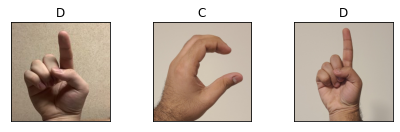

In [ ]:
# location
small_path = '/content/drive/My Drive/U of T/APS360 Deep Learning/Lab3smalldata'

# Transform Settings
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

small_dataset = torchvision.datasets.ImageFolder(small_path, transform=transform)

# Prepare Dataloader
batch_size = 3
num_workers = 1

small_loader = torch.utils.data.DataLoader(small_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Visualize some sample data
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# obtain one batch of training images
dataiter = iter(small_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(3):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
# Train the Model and try to overfit
CNN = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  CNN.cuda()

overfit(CNN, small_loader);

Epoch: 0, Accuracy: 0.11490215755143
Epoch: 1, Accuracy: 0.15955845459106874
Epoch: 2, Accuracy: 0.24335173105870547
Epoch: 3, Accuracy: 0.2719518314099348
Epoch: 4, Accuracy: 0.31159056698444554
Epoch: 5, Accuracy: 0.3567486201705971
Epoch: 6, Accuracy: 0.39287506271951833
Epoch: 7, Accuracy: 0.41495233316608127
Epoch: 8, Accuracy: 0.4139488208730557
Epoch: 9, Accuracy: 0.4430506773707978
Epoch: 10, Accuracy: 0.44706472654290014
Epoch: 11, Accuracy: 0.44756648268941296
Epoch: 12, Accuracy: 0.4756648268941295
Epoch: 13, Accuracy: 0.4882087305569493
Epoch: 14, Accuracy: 0.49573507275464124
Epoch: 15, Accuracy: 0.4992473657802308
Epoch: 16, Accuracy: 0.5153035624686403
Epoch: 17, Accuracy: 0.5052684395383843
Epoch: 18, Accuracy: 0.5163070747616658
Epoch: 19, Accuracy: 0.5464124435524336
Epoch: 20, Accuracy: 0.5318615153035625
Epoch: 21, Accuracy: 0.5429001505268439
Epoch: 22, Accuracy: 0.5484194681384847
Epoch: 23, Accuracy: 0.5444054189663824
Epoch: 24, Accuracy: 0.5494229804315103
Epoc

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
# three hyperparameters to tune are: kernel size of the convolutional layers, number of epoches, batch number

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
# default
CNN = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  CNN.cuda()

train_acc, val_acc, epochs = train(CNN, train_dataset, val_dataset)

plt.plot(epochs, train_acc)
plt.title("Training Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Validation Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

Training Started...
Epoch 0: Train acc: 0.13045659809332663 |Validation acc: 0.1348314606741573


AttributeError: ignored

In [ ]:
# tuning the kernel sizes, but keep number of epochs and batch number the same
CNN = CNNClassifier(kernel_sizes = [3, 5, 10])
if use_cuda and torch.cuda.is_available():
  CNN.cuda()

train(CNN, train_dataset, val_dataset)

# it appears that the model performs better

In [ ]:
# tuning the number of epoches and the batch number with the new kernel sizes since it has a better performance
CNN = CNNClassifier(kernel_sizes = [3, 5, 10])
if use_cuda and torch.cuda.is_available():
  CNN.cuda()

train(CNN, train_dataset, val_dataset, batch_size=256, num_epochs=20)

# it appears that increasing the number of epocbes leads to overfitting 

In [ ]:
# tuning the batch number but keep kernel sizes changed and number of epoches unchanged(default number)
CNN = CNNClassifier(kernel_sizes = [3, 5, 10])
if use_cuda and torch.cuda.is_available():
  CNN.cuda()

train_acc, val_acc, epochs = train(CNN, train_dataset, val_dataset, batch_size=450)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
# by further tuning the number of epochs, epoch number equal to 16 yiels the best result
# the final model has the kernal sizes of 3 for the first convolutional layer, 5 for the second, and 10 for the last convolutional layer
# it has a batch number of 450 and a epoch number of 16, with a learning rate of 0.01

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
get_accuracy(CNN, test_loader)

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
# features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
# Save Features to Folder 
import os

# location on Google Drive
master_path = '/content/drive/My Drive/U of T/APS360 Deep Learning/Lab3new'

# Prepare Dataloader
batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# save features to folder as tensors
n = 0
for img, label in train_data_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/train/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

n = 0
for img, label in val_data_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/val/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.chdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

n = 0
for img, label in test_data_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/test/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.chdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
# output = model(features)
# prob = F.softmax(output)

In [ ]:
# all the features are saved in Lab3new drive

#load features
# location on Google Drive
master_path = '/content/drive/My Drive//U of T/APS360 Deep Learning/Lab3new/'

# get all the features from different folders
train_features = torchvision.datasets.DatasetFolder(master_path + 'train', loader=torch.load, extensions=('.tensor'))
val_features = torchvision.datasets.DatasetFolder(master_path + 'val', loader=torch.load, extensions=('.tensor'))
test_features = torchvision.datasets.DatasetFolder(master_path + 'test', loader=torch.load, extensions=('.tensor'))

# Prepare Dataloader
batch_size = 32
num_workers = 1
train_feature_loader = torch.utils.data.DataLoader(train_features, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_feature_loader = torch.utils.data.DataLoader(val_features, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_feature_loader = torch.utils.data.DataLoader(test_features, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(train_feature_loader)
features, labels = next(dataiter)
print(features.shape) # [batch number, number of channels, height, width]
print(labels.shape)

torch.Size([32, 256, 6, 6])
torch.Size([32])


In [ ]:
torch.manual_seed(10) # set the random seed
from math import floor

class AlexClassifier(nn.Module):
    def __init__(self, name = "AlexNet_Classifier"):
        super(AlexClassifier, self).__init__()
        self.conv1 = nn.Conv2d(256, 512, 3)
        self.pool = nn.MaxPool2d(2, 2)

        # Computing the correct input size into the Fully Connected Layer
        self.x = floor((6 - 3 + 1)/2)
        self.FC_input = 512*self.x*self.x

        self.fc1 = nn.Linear(self.FC_input, 32)
        self.fc2 = nn.Linear(32, 9)

        self.name = name        

    def forward(self, features):
        x = self.pool(F.relu(self.conv1(features)))
        x = x.view(-1, self.FC_input)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
#tensor = torch.from_numpy(tensor.detach().numpy())

In [ ]:
net = AlexClassifier()
if use_cuda and torch.cuda.is_available():
  net.cuda()

train(net, train_features, val_features)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
get_accuracy(net, test_feature_loader)

0.07407407407407407

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
# the accuracy in part 4d is 0.914 which is pretty good
# a real behind it is that we used pretrained method from AlexNet, which has data inputs of millions of images
# with such a large data, the weights are biases are more accurate
# the only thing we need to do is to adapt the parameters to our existing data inputs
# therefore, the model is pretty accurate 